In [13]:
import torch
import pickle
from models import mobilenetv2, resnet56
from torchvision.models import resnet50
from embedl.plumbing.torch.metrics.target import Target
from embedl.torch.pruning.methods import UniformPruning
from embedl.torch.viewer import view_model
from embedl.torch.metrics.performances import Flops  
from embedl.torch.metrics.measure_performance import measure_flops
import torchvision.datasets as datasets
from embedl.torch.pruning.methods import plot_pruning_profile 
import torchvision.transforms as transforms
import torch.nn as nn
from embedl.torch.metrics.performances import Flops
from embedl.torch.pruning.methods import (
    PruningMethod,
    ChannelPruningTactic,
)
from embedl.plumbing.torch.metrics.scorers import ChannelPruningScorer, PruningBalancer
from embedl.torch.metrics.importance_scores import WeightMagnitude
from embedl.plumbing.torch.pruning.method import apply_pruning_steps

normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]
)

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        root="/home/jonna/data",
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                normalize,
            ]
        ),
    ),
    batch_size=128,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def validate(val_loader, model, criterion):
    """
    Run evaluation
    """

    prec1 = 0
    count = 0
    # switch to evaluate mode
    model.eval()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 += accuracy(output.data, target)[0] * target.size(0)
            # print(accuracy(output.data, target)[0])
            count += target.size(0)

    print(f" * Prec@1 {prec1/count:.3f}")
    return

In [27]:
state = torch.load(
    "/home/jonna/hyperparameter_sensitivity_pruning/experiments/imagenet/base_model/3_3_grid/results/lr_10**-1.00_wd_10**-4.00/checkpoint_middle.pth"
)
model = resnet50()
model.load_state_dict(state["model"])
model.cuda()

input_shape = [1, 3, 224, 224]

base_flops = measure_flops(model, input_shape=input_shape)
print(base_flops)
exclude_ops = [
                "conv1",
                "layer1_0_downsample_0",
                "layer2_0_downsample_0",
                "layer3_0_downsample_0",
                "layer4_0_downsample_0",
                "layer4_2_conv3",
                "layer4_1_conv3",
                "layer4_0_conv3",
                "layer3_5_conv3",
                "layer3_4_conv3",
                "layer3_3_conv3",
                "layer3_2_conv3",
                "layer3_1_conv3",
                "layer3_0_conv3",
                "layer2_3_conv3",
                "layer2_2_conv3",
                "layer2_1_conv3",
                "layer2_0_conv3",
                "layer1_2_conv3",
                "layer1_1_conv3",
                "layer1_0_conv3",
        ]
include_ops = ['layer1_0_conv2']
scorer = ChannelPruningScorer(
    importance_score=WeightMagnitude(), channel_pruning_balancer=None
)
tactic = ChannelPruningTactic(step_size=1, search_depth=1, speedup_pruning=False)
pruning_method = PruningMethod(
    scorer,
    [tactic],
    target=Target(Flops(), fraction=0.99),
    include_ops=include_ops
)
pruning_steps = pruning_method.prune(model, input_shape=input_shape)

pruned_flops = measure_flops(model=model, input_shape=input_shape)
print(pruned_flops / base_flops)  # 0.39987710179444597
# torch.save(model, "pruned_models/resnet50_magnitude_40_noexcl.th")
view_model(model, compare_with=resnet50())

# with open("pruned_models/pruningsteps_resnet50_magnitude_40_noexcl.th", "wb") as f:
  #  pickle.dump(pruning_steps, f)

100%|██████████| [00:37<00:00, 3734.60s/it] (Flops) 


8242043856


 95%|█████████▍| [00:01<00:00, 129.61s/it] (Flops) WARNING:embedl.plumbing.torch.core.module_processing:Found nodes whose (<class 'embedl.plumbing.torch.viewer.viewer_configs.ViewerConfig'>,) uses the default <embedl.plumbing.torch.viewer.viewer_configs.DefaultViewerConfig object at 0x7fe0c6b9b7f0>: 


0.9899322836119595
Args: {'model1': PosixPath('/tmp/tmpsk8c9ui6/comparison_network.json'), 'model2': PosixPath('/tmp/tmpsk8c9ui6/exported_network.json'), 'port': None, 'force': True}
Creating symlink /tmp/embedl-viewer-srt99xj3/comparison_network.json -> /tmp/tmpsk8c9ui6/comparison_network.json
Creating symlink /tmp/embedl-viewer-srt99xj3/exported_network.json -> /tmp/tmpsk8c9ui6/exported_network.json
Opening embedl-viewer in browser
Serving /tmp/embedl-viewer-srt99xj3 at port 8000



127.0.0.1 - - [17/May/2023 14:19:44] "GET /comparison_network.json HTTP/1.1" 200 -
127.0.0.1 - - [17/May/2023 14:19:44] "GET /exported_network.json HTTP/1.1" 200 -


KeyboardInterrupt: 

In [26]:
view_model(model, compare_with=resnet50())


Args: {'model1': PosixPath('/tmp/tmpqcuixfdb/comparison_network.json'), 'model2': PosixPath('/tmp/tmpqcuixfdb/exported_network.json'), 'port': None, 'force': True}
Creating symlink /tmp/embedl-viewer-hlztok20/comparison_network.json -> /tmp/tmpqcuixfdb/comparison_network.json
Creating symlink /tmp/embedl-viewer-hlztok20/exported_network.json -> /tmp/tmpqcuixfdb/exported_network.json
Opening embedl-viewer in browser
Serving /tmp/embedl-viewer-hlztok20 at port 8001



127.0.0.1 - - [17/May/2023 14:19:12] "GET /comparison_network.json HTTP/1.1" 200 -
127.0.0.1 - - [17/May/2023 14:19:12] "GET /exported_network.json HTTP/1.1" 200 -


KeyboardInterrupt: 

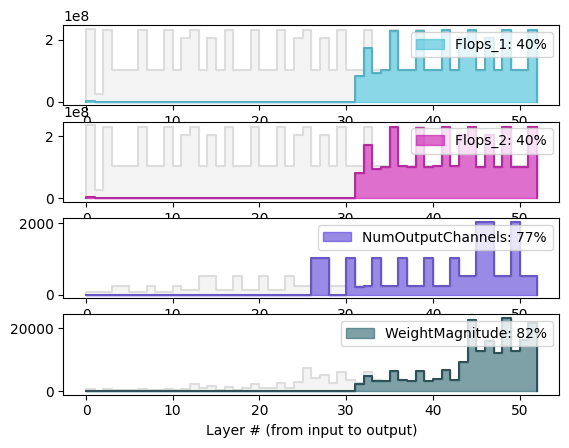

In [10]:
plot_pruning_profile(model, pruning_steps)

In [29]:
model1 = torch.load('/home/jonna/pytorch_resnet_cifar10/pruned_models/resnet50_magnitude_40_noexcl.th')
model2 = torch.load('/home/jonna/pytorch_resnet_cifar10/pruned_models/resnet50_magnitude_40.th')
model3 = torch.load('/home/jonna/pytorch_resnet_cifar10/pruned_models/resnet56_magnitude_60.th')
view_model(model2, compare_with=resnet50())

Args: {'model1': PosixPath('/tmp/tmpr7f3k9mg/comparison_network.json'), 'model2': PosixPath('/tmp/tmpr7f3k9mg/exported_network.json'), 'port': None, 'force': True}
Creating symlink /tmp/embedl-viewer-_ye0dmv5/comparison_network.json -> /tmp/tmpr7f3k9mg/comparison_network.json
Creating symlink /tmp/embedl-viewer-_ye0dmv5/exported_network.json -> /tmp/tmpr7f3k9mg/exported_network.json
Opening embedl-viewer in browser
Serving /tmp/embedl-viewer-_ye0dmv5 at port 8000



127.0.0.1 - - [17/May/2023 14:23:42] "GET /comparison_network.json HTTP/1.1" 200 -
127.0.0.1 - - [17/May/2023 14:23:42] "GET /exported_network.json HTTP/1.1" 200 -


KeyboardInterrupt: 